In [1]:
import sys
sys.path.append("/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/svg2plan/_scripts")

import networkx as nx

from svg_reader import SVGReader
from adjacencies.adjacency import AdjacencyGenerator

from placement.executer import PlacementExecuter

from svg_helpers.saver import Saver, read_layout
from svg_helpers.plotter import Plotter
from svg_helpers.layout import Layout
from svg_helpers.directions import Direction
from dataclasses import dataclass

from enum import Enum

from adjacencies.connectivity import ConnectivityGenerator

In [2]:
svg_name = "amber_building_a_f01.svg"
sv = SVGReader(svg_name)
sv.run()

In [3]:
ag = AdjacencyGenerator(sv.domains)
ag.run()

In [4]:
cg = ConnectivityGenerator(ag.positioned_graph)
cg.run()

In [5]:
[i.toJson() for i in cg.G_json["nodes"][0]["window"]]

KeyError: 'window'

In [6]:
for item in cg.G_json["nodes"]:
    item["data"] = item["data"].toJson()
    item["window"] = [i.toJson() for i in item["window"]]

In [7]:
item

{'data': '{"NORTH": [], "SOUTH": ["transit_space"], "EAST": ["m_bath", "bath"], "WEST": ["bedroom_1"]}',
 'window': [{'direction': 'NORTH', 'window_type': 'A'}],
 'id': 'laundry'}

In [5]:
cg.G.nodes(True)["bath"]["data"].toJson()

'{"NORTH": ["m_bath"], "SOUTH": ["dining"], "EAST": ["m_bedroom"], "WEST": ["transit_space", "laundry"]}'

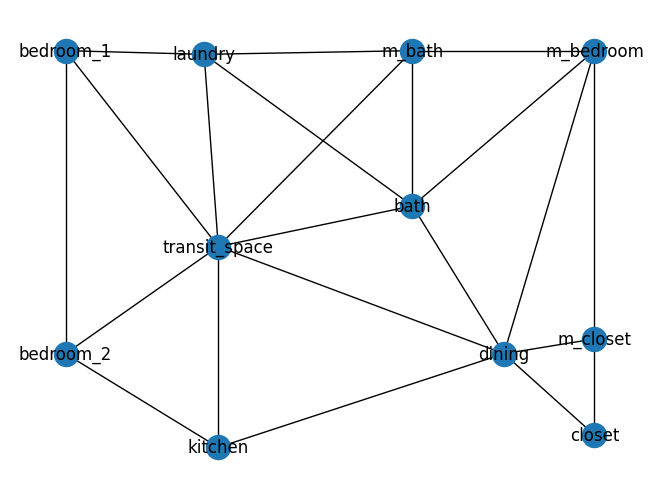

In [4]:
ag.draw_graph()

In [5]:
for key, data in ag.G.nodes(data=True):
    print(key, data["data"].get_empty_directions())



bedroom_1 ['NORTH', 'WEST']
kitchen ['SOUTH']
m_bath ['NORTH']
m_bedroom ['NORTH', 'EAST']
m_closet ['EAST']
bath []
dining ['SOUTH']
transit_space []
closet ['SOUTH', 'EAST']
bedroom_2 ['SOUTH', 'WEST']
laundry ['NORTH']


In [6]:
class WindowType(Enum):
    A = 0
    B = 1
@dataclass
class Window:
    direction: Direction
    type: WindowType


In [13]:
G_window = ag.G.copy()

for key, data in G_window.nodes(data=True):
    data["window"] = []
    empty_dir  = data["data"].get_empty_directions()
    for d in empty_dir:
        if d == Direction.NORTH.name or  d == Direction.SOUTH.name:
            data["window"].append(Window(d, WindowType.A))
    
G_window.nodes(data=True)

NodeDataView({'bedroom_1': {'data': NeighborDirections(NORTH=[], SOUTH=['bedroom_2'], EAST=['transit_space', 'laundry'], WEST=[]), 'window': [Window(direction='NORTH', type=<WindowType.A: 0>)]}, 'kitchen': {'data': NeighborDirections(NORTH=['transit_space'], SOUTH=[], EAST=['dining'], WEST=['bedroom_2']), 'window': [Window(direction='SOUTH', type=<WindowType.A: 0>)]}, 'm_bath': {'data': NeighborDirections(NORTH=[], SOUTH=['bath', 'transit_space'], EAST=['m_bedroom'], WEST=['transit_space', 'laundry']), 'window': [Window(direction='NORTH', type=<WindowType.A: 0>)]}, 'm_bedroom': {'data': NeighborDirections(NORTH=[], SOUTH=['m_closet', 'dining'], EAST=[], WEST=['m_bath', 'bath']), 'window': [Window(direction='NORTH', type=<WindowType.A: 0>)]}, 'm_closet': {'data': NeighborDirections(NORTH=['m_bedroom'], SOUTH=['closet'], EAST=[], WEST=['dining']), 'window': []}, 'bath': {'data': NeighborDirections(NORTH=['m_bath'], SOUTH=['dining'], EAST=['m_bedroom'], WEST=['transit_space', 'laundry']),

In [26]:
Direction["NORTH"]

<Direction.NORTH: 0>

## internal doors

In [14]:
# Edge = namedtuple("Edge", ["edge", "is_linked"])

@dataclass
class Edge:
    edge: tuple
    is_linked: bool

In [15]:
# connectivity graph..
conn = {} 
for ix, e in enumerate(G_window.edges):
    # conn[e] = False
    conn[ix] = Edge(e, False)

In [16]:
for k, v in conn.items():
    print(k, v.edge)

0 ('bedroom_1', 'transit_space')
1 ('bedroom_1', 'bedroom_2')
2 ('bedroom_1', 'laundry')
3 ('kitchen', 'dining')
4 ('kitchen', 'transit_space')
5 ('kitchen', 'bedroom_2')
6 ('m_bath', 'm_bedroom')
7 ('m_bath', 'bath')
8 ('m_bath', 'transit_space')
9 ('m_bath', 'laundry')
10 ('m_bedroom', 'm_closet')
11 ('m_bedroom', 'bath')
12 ('m_bedroom', 'dining')
13 ('m_closet', 'dining')
14 ('m_closet', 'closet')
15 ('bath', 'dining')
16 ('bath', 'transit_space')
17 ('bath', 'laundry')
18 ('dining', 'transit_space')
19 ('dining', 'closet')
20 ('transit_space', 'bedroom_2')
21 ('transit_space', 'laundry')


In [17]:
conn[0].is_linked = True
conn[3].is_linked = True
conn[6].is_linked = True
conn[10].is_linked = True
conn[12].is_linked = True
conn[16].is_linked = True
conn[18].is_linked = True
conn[19].is_linked = True
conn[20].is_linked = True
conn[21].is_linked = True


In [ ]:
linked_edges = [0,3,6,10,12,16,18,19,20,21]

In [18]:
for k, v in conn.items():
    if not v.is_linked:
        print(k, v.edge)

1 ('bedroom_1', 'bedroom_2')
2 ('bedroom_1', 'laundry')
4 ('kitchen', 'transit_space')
5 ('kitchen', 'bedroom_2')
7 ('m_bath', 'bath')
8 ('m_bath', 'transit_space')
9 ('m_bath', 'laundry')
11 ('m_bedroom', 'bath')
13 ('m_closet', 'dining')
14 ('m_closet', 'closet')
15 ('bath', 'dining')
17 ('bath', 'laundry')


In [19]:
# some tests ...
# transit space has 5 links 
# mbed is connected to m_closet and m_bath

def test_edge(e):
    return frozenset(e) in [frozenset(v.edge) for v in conn.values()]
 
def test_transit_space(conn):
    n_expected = 5
    counter = 0
    nbs = []
    for k, v in conn.items():
        if v.is_linked and "transit_space" in v.edge:
            nbs.append(v.edge)
            counter+=1
    if counter != n_expected:
        print(f"neighbors: {[sorted(n) for n in nbs]}")
        raise Exception("Edge test failed")
    
def test_m_bedroom(conn):
    for room in ["bath", "m_closet"]:
        assert test_edge((room, "m_bedroom"))
        
        
test_transit_space()
test_m_bedroom()

In [29]:
from typing import Callable, Dict


In [30]:
def hello(l:list[Callable[[Dict[str, int]], bool]]):
    myd = {"hi": 0}
    for fx in l:
        print(fx(myd))


In [ ]:
type string_dict = Dict[str, int]

In [31]:
def fx1(yo:Dict[str, int]) -> bool:
        print(yo.keys())
        return True

In [32]:
hello([fx1, fx1])

dict_keys(['hi'])
True
dict_keys(['hi'])
True


In [20]:
# form connectivity graph .. 
G_conn = G_window.copy()
for e in G_conn.edges:
    if e not in [v.edge for v in conn.values() if v.is_linked == True]:
        G_conn.remove_edge(*e)

In [21]:
assert len(G_conn.edges()) < len(G_window.edges)

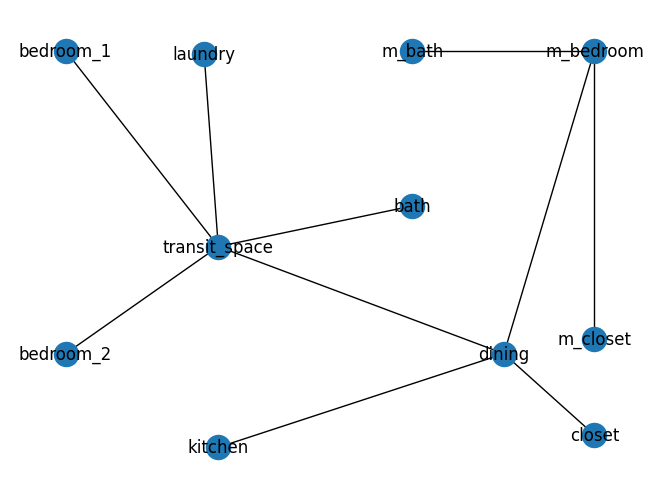

In [22]:
nx.draw(G_conn, ag.fp_layout, with_labels=True)

In [23]:
G_conn.nodes(True)

NodeDataView({'bedroom_1': {'data': NeighborDirections(NORTH=[], SOUTH=['bedroom_2'], EAST=['transit_space', 'laundry'], WEST=[]), 'window': [Window(direction='NORTH', type=<WindowType.A: 0>)]}, 'kitchen': {'data': NeighborDirections(NORTH=['transit_space'], SOUTH=[], EAST=['dining'], WEST=['bedroom_2']), 'window': [Window(direction='SOUTH', type=<WindowType.A: 0>)]}, 'm_bath': {'data': NeighborDirections(NORTH=[], SOUTH=['bath', 'transit_space'], EAST=['m_bedroom'], WEST=['transit_space', 'laundry']), 'window': [Window(direction='NORTH', type=<WindowType.A: 0>)]}, 'm_bedroom': {'data': NeighborDirections(NORTH=[], SOUTH=['m_closet', 'dining'], EAST=[], WEST=['m_bath', 'bath']), 'window': [Window(direction='NORTH', type=<WindowType.A: 0>)]}, 'm_closet': {'data': NeighborDirections(NORTH=['m_bedroom'], SOUTH=['closet'], EAST=[], WEST=['dining']), 'window': []}, 'bath': {'data': NeighborDirections(NORTH=['m_bath'], SOUTH=['dining'], EAST=['m_bedroom'], WEST=['transit_space', 'laundry']),

In [24]:
nx.node_link_data(G_conn)

{'directed': False,
 'multigraph': False,
 'graph': {},
 'nodes': [{'data': NeighborDirections(NORTH=[], SOUTH=['bedroom_2'], EAST=['transit_space', 'laundry'], WEST=[]),
   'window': [Window(direction='NORTH', type=<WindowType.A: 0>)],
   'id': 'bedroom_1'},
  {'data': NeighborDirections(NORTH=['transit_space'], SOUTH=[], EAST=['dining'], WEST=['bedroom_2']),
   'window': [Window(direction='SOUTH', type=<WindowType.A: 0>)],
   'id': 'kitchen'},
  {'data': NeighborDirections(NORTH=[], SOUTH=['bath', 'transit_space'], EAST=['m_bedroom'], WEST=['transit_space', 'laundry']),
   'window': [Window(direction='NORTH', type=<WindowType.A: 0>)],
   'id': 'm_bath'},
  {'data': NeighborDirections(NORTH=[], SOUTH=['m_closet', 'dining'], EAST=[], WEST=['m_bath', 'bath']),
   'window': [Window(direction='NORTH', type=<WindowType.A: 0>)],
   'id': 'm_bedroom'},
  {'data': NeighborDirections(NORTH=['m_bedroom'], SOUTH=['closet'], EAST=[], WEST=['dining']),
   'window': [],
   'id': 'm_closet'},
  {'da